In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import glob
import os
import json

from torch.optim import Adam


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


# Dataset Class

In [2]:
class LandslideDataset(Dataset):
    def __init__(self, root_dir, array_size=128, apply_scaling=False):
        self.array_size = array_size
        self.data_files = []
        self.model_ids = []  # List to store the model IDs
        self.terrain_files = {}
        self.apply_scaling = apply_scaling

        def get_state_number(file_path):
            return int(file_path.split('_')[-1].split('.')[0])

        model_dirs = glob.glob(os.path.join(root_dir, '*'))
        
        for model_dir in model_dirs:
            if os.path.isdir(model_dir):
                # Extract the model ID from the model_dir path
                model_id = os.path.basename(model_dir)

                file_patterns = {
                    'velocity': os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'velocity', '*_velocity_*.npy'),
                    'thickness': os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'thickness', '*_thickness_*.npy')
                }
                file_collections = {key: sorted(glob.glob(pattern), key=get_state_number) for key, pattern in file_patterns.items()}

                terrain_pattern = os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'elevation', '*_elevation.npy')
                terrain_file = glob.glob(terrain_pattern)

                if terrain_file:
                    self.terrain_files[model_dir] = terrain_file[0]

                for i in range(len(file_collections['velocity']) - 1):
                    current_state_velocity = get_state_number(file_collections['velocity'][i])
                    next_state_velocity = get_state_number(file_collections['velocity'][i + 1])
                    current_state_thickness = get_state_number(file_collections['thickness'][i])
                    next_state_thickness = get_state_number(file_collections['thickness'][i + 1])

                    if (next_state_velocity == current_state_velocity + 1) and (next_state_thickness == current_state_thickness + 1):
                        self.data_files.append((file_collections['velocity'][i], file_collections['velocity'][i + 1],
                                                file_collections['thickness'][i], file_collections['thickness'][i + 1]))
                        # Append the model_id for each valid data point
                        self.model_ids.append(model_id)

    def compute_scaling_factors(self):
        # Ensure that scaling is intended before computing factors
        if not self.apply_scaling:
            raise RuntimeError("Scaling factors called to be computed when scaling is not applied.")

        # Initialize min and max values with infinities
        self.min_elevation = np.inf
        self.max_elevation = -np.inf
        self.min_velocity = np.inf
        self.max_velocity = -np.inf
        self.min_thickness = np.inf
        self.max_thickness = -np.inf

        # Compute min and max values over the training set
        for model_dir, terrain_path in self.terrain_files.items():
            terrain = np.load(terrain_path)
            self.min_elevation = min(self.min_elevation, terrain.min())
            self.max_elevation = max(self.max_elevation, terrain.max())

            # Assuming that velocity and thickness files are matched in the data_files
            for velocity_path, _, thickness_path, _ in self.data_files:
                if model_dir in velocity_path:  # Checking if the file belongs to the current model directory
                    velocity = np.load(velocity_path)
                    thickness = np.load(thickness_path)
                    self.min_velocity = min(self.min_velocity, velocity.min())
                    self.max_velocity = max(self.max_velocity, velocity.max())
                    self.min_thickness = min(self.min_thickness, thickness.min())
                    self.max_thickness = max(self.max_thickness, thickness.max())

    def scale_data(self, terrain, velocity, thickness):
        # Apply Min-Max scaling to each feature
        terrain_scaled = (terrain - self.min_elevation) / (self.max_elevation - self.min_elevation) * 10
        velocity_scaled = (velocity - self.min_velocity) / (self.max_velocity - self.min_velocity) * 10 
        thickness_scaled = (thickness - self.min_thickness) / (self.max_thickness - self.min_thickness) * 10
        return terrain_scaled, velocity_scaled, thickness_scaled


    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        current_velocity_path, next_velocity_path, current_thickness_path, next_thickness_path = self.data_files[idx]
        
        # Load current and next states for velocity and thickness
        current_velocity = np.load(current_velocity_path)
        next_velocity = np.load(next_velocity_path)
        current_thickness = np.load(current_thickness_path)
        next_thickness = np.load(next_thickness_path)

        # Get the model directory from the current velocity path
        model_dir = os.path.dirname(os.path.dirname(os.path.dirname(current_velocity_path)))

        # Load the corresponding terrain file
        terrain_path = self.terrain_files[model_dir]
        terrain = np.load(terrain_path)

        if self.apply_scaling:
            # Apply scaling to the loaded data
            terrain_scaled, current_velocity_scaled, current_thickness_scaled = self.scale_data(
                terrain, current_velocity, current_thickness
            )
            _, next_velocity_scaled, next_thickness_scaled = self.scale_data(
                terrain, next_velocity, next_thickness
            )
        else:
            # No scaling applied, use the original values
            terrain_scaled, current_velocity_scaled, current_thickness_scaled = terrain, current_velocity, current_thickness
            next_velocity_scaled, next_thickness_scaled = next_velocity, next_thickness

        # Stack arrays as channels for CNN input and output
        cnn_input = np.stack((terrain_scaled, current_velocity_scaled, current_thickness_scaled), axis=0)
        cnn_output = np.stack((next_velocity_scaled, next_thickness_scaled), axis=0)


        return torch.from_numpy(cnn_input).float(), torch.from_numpy(cnn_output).float()


    def create_dataloaders(self, split_proportions, batch_size, random_state=42):
        # Unpack the proportions for clarity
        train_proportion, val_proportion, test_proportion = split_proportions
        
        # Assert that the proportions sum to 1
        assert np.isclose(sum(split_proportions), 1.0), "Proportions must sum up to 1."
        
        # Create a list of unique model IDs
        unique_model_ids = np.unique(self.model_ids)
        
        # Split model IDs into train, val, and test sets
        train_model_ids, temp_model_ids = train_test_split(
            unique_model_ids, test_size=(val_proportion + test_proportion), random_state=random_state
        )
        val_model_ids, test_model_ids = train_test_split(
            temp_model_ids, test_size=test_proportion / (val_proportion + test_proportion), random_state=random_state
        )
        
        # Now, filter the dataset's data points based on the model IDs
        train_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in train_model_ids]
        val_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in val_model_ids]
        test_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in test_model_ids]
        
        # Create subsets
        train_dataset = Subset(self, train_indices)
        val_dataset = Subset(self, val_indices)
        test_dataset = Subset(self, test_indices)
        
        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Return the DataLoaders
        return train_loader, val_loader, test_loader

In [3]:
# class LandslideDataset(Dataset):
#     def __init__(self, root_dir, array_size=128):
#         self.array_size = array_size
#         self.data_files = []
#         self.model_ids = []  # List to store the model IDs
#         self.terrain_files = {}

#         def get_state_number(file_path):
#             return int(file_path.split('_')[-1].split('.')[0])

#         model_dirs = glob.glob(os.path.join(root_dir, '*'))
        
#         for model_dir in model_dirs:
#             if os.path.isdir(model_dir):
#                 # Extract the model ID from the model_dir path
#                 model_id = os.path.basename(model_dir)

#                 file_patterns = {
#                     'velocity': os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'velocity', '*_velocity_*.npy'),
#                     'thickness': os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'thickness', '*_thickness_*.npy')
#                 }
#                 file_collections = {key: sorted(glob.glob(pattern), key=get_state_number) for key, pattern in file_patterns.items()}

#                 terrain_pattern = os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'elevation', '*_elevation.npy')
#                 terrain_file = glob.glob(terrain_pattern)

#                 if terrain_file:
#                     self.terrain_files[model_dir] = terrain_file[0]

#                 for i in range(len(file_collections['velocity']) - 1):
#                     current_state_velocity = get_state_number(file_collections['velocity'][i])
#                     next_state_velocity = get_state_number(file_collections['velocity'][i + 1])
#                     current_state_thickness = get_state_number(file_collections['thickness'][i])
#                     next_state_thickness = get_state_number(file_collections['thickness'][i + 1])

#                     if (next_state_velocity == current_state_velocity + 1) and (next_state_thickness == current_state_thickness + 1):
#                         self.data_files.append((file_collections['velocity'][i], file_collections['velocity'][i + 1],
#                                                 file_collections['thickness'][i], file_collections['thickness'][i + 1]))
#                         # Append the model_id for each valid data point
#                         self.model_ids.append(model_id)
        
#     def __len__(self):
#         return len(self.data_files)

#     def __getitem__(self, idx):
#         current_velocity_path, next_velocity_path, current_thickness_path, next_thickness_path = self.data_files[idx]
        
#         # Load current and next states for velocity and thickness
#         current_velocity = np.load(current_velocity_path)
#         next_velocity = np.load(next_velocity_path)
#         current_thickness = np.load(current_thickness_path)
#         next_thickness = np.load(next_thickness_path)

#         # Get the model directory from the current velocity path
#         model_dir = os.path.dirname(os.path.dirname(os.path.dirname(current_velocity_path)))

#         # Load the corresponding terrain file
#         terrain_path = self.terrain_files[model_dir]
#         terrain = np.load(terrain_path)

#         # Stack terrain, current velocity, and current thickness arrays as channels for CNN input
#         cnn_input = np.stack((terrain, current_velocity, current_thickness), axis=0)

#         # Stack next velocity and next thickness arrays as channels for CNN output
#         cnn_output = np.stack((next_velocity, next_thickness), axis=0)

#         return torch.from_numpy(cnn_input).float(), torch.from_numpy(cnn_output).float()


#     def create_dataloaders(self, split_proportions, batch_size, random_state=42):
#         # Unpack the proportions for clarity
#         train_proportion, val_proportion, test_proportion = split_proportions
        
#         # Assert that the proportions sum to 1
#         assert np.isclose(sum(split_proportions), 1.0), "Proportions must sum up to 1."
        
#         # Create a list of unique model IDs
#         unique_model_ids = np.unique(self.model_ids)
        
#         # Split model IDs into train, val, and test sets
#         train_model_ids, temp_model_ids = train_test_split(
#             unique_model_ids, test_size=(val_proportion + test_proportion), random_state=random_state
#         )
#         val_model_ids, test_model_ids = train_test_split(
#             temp_model_ids, test_size=test_proportion / (val_proportion + test_proportion), random_state=random_state
#         )
        
#         # Now, filter the dataset's data points based on the model IDs
#         train_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in train_model_ids]
#         val_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in val_model_ids]
#         test_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in test_model_ids]
        
#         # Create subsets
#         train_dataset = Subset(self, train_indices)
#         val_dataset = Subset(self, val_indices)
#         test_dataset = Subset(self, test_indices)
        
#         # DataLoaders
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#         test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
#         # Return the DataLoaders
#         return train_loader, val_loader, test_loader

# Models


## Complex CNN

In [4]:
class Complex_CNN(nn.Module):
    def __init__(self):
        super(Complex_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 3 channels, Output: 32 channels
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 2, kernel_size=3, padding=1)  # Output: 2 channels (velocity and thickness)

    def forward(self, x):
        # Encoder path
        x1 = F.relu(self.bn1(self.conv1(x)))     # 64x64x32
        x2 = self.pool(x1)                       # 32x32x32
        x3 = F.relu(self.bn2(self.conv2(x2)))    # 32x32x64
        x4 = self.pool(x3)                       # 16x16x64
        x5 = F.relu(self.bn3(self.conv3(x4)))    # 16x16x128
        x6 = self.pool(x5)                       # 8x8x128
        x7 = F.relu(self.bn4(self.conv4(x6)))    # 8x8x256

        # Decoder path
        x8 = self.up(x7)                         # 16x16x256
        x9 = F.relu(self.bn5(self.conv5(x8)))    # 16x16x128
        x10 = self.up(x9)                        # 32x32x128
        x11 = F.relu(self.bn6(self.conv6(x10)))  # 32x32x64
        x12 = self.up(x11)                       # 64x64x64

        # Output layer
        x13 = self.conv7(x12)                    # 64x64x2
        return x13

## UNet

In [5]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Define the U-Net architecture
        # Contracting Path (Encoder)
        self.enc_conv0 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Expanding Path (Decoder)
        self.up_conv0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dec_conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)  # Output: 1 channel (velocity)

    def forward(self, x):
        # Encoder
        enc0 = F.relu(self.enc_conv0(x))
        enc1 = F.relu(self.enc_conv1(self.pool(enc0)))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Decoder
        dec2 = F.relu(self.dec_conv1(torch.cat((self.up_conv0(enc3), enc2), dim=1)))
        dec1 = F.relu(self.dec_conv2(torch.cat((self.up_conv1(dec2), enc1), dim=1)))
        dec0 = F.relu(self.dec_conv3(torch.cat((self.up_conv2(dec1), enc0), dim=1)))

        # Final convolution
        return self.final_conv(dec0)

In [6]:
class LargeUNet(nn.Module):
    def __init__(self):
        super(LargeUNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc_conv0 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn0 = nn.BatchNorm2d(64)
        self.enc_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.enc_conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)

        self.pool = nn.MaxPool2d(2, 2)

        # Expanding Path (Decoder)
        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dec_conv4 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec_bn4 = nn.BatchNorm2d(512)
        self.dec_conv3 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(256)
        self.dec_conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(128)
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc0 = F.relu(self.bn0(self.enc_conv0(x)))
        enc1 = F.relu(self.bn1(self.enc_conv1(self.pool(enc0))))
        enc2 = F.relu(self.bn2(self.enc_conv2(self.pool(enc1))))
        enc3 = F.relu(self.bn3(self.enc_conv3(self.pool(enc2))))
        enc4 = F.relu(self.bn4(self.enc_conv4(self.pool(enc3))))

        # Decoder
        dec3 = F.relu(self.dec_bn4(self.dec_conv4(torch.cat((self.up_conv1(enc4), enc3), dim=1))))
        dec2 = F.relu(self.dec_bn3(self.dec_conv3(torch.cat((self.up_conv0(dec3), enc2), dim=1))))
        dec1 = F.relu(self.dec_bn2(self.dec_conv2(torch.cat((self.up_conv_1(dec2), enc1), dim=1))))
        dec0 = F.relu(self.dec_bn1(self.dec_conv1(torch.cat((self.up_conv_2(dec1), enc0), dim=1))))

        # Final convolution
        return self.final_conv(dec0)

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512, 1024]):
        super(UNet, self).__init__()
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder path
        for feature in features:
            self.encoders.append(
                UNet._block(in_channels, feature)
            )
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = UNet._block(features[-1], features[-1] * 2)

        # Decoder path
        for feature in reversed(features):
            self.decoders.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoders.append(
                UNet._block(feature * 2, feature)
            )
        
        # Final convolution
        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skip_connections = []

        # Encoder
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse the skip connections
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.decoders), 2):
            x = self.decoders[idx](x)
            skip_connection = skip_connections[idx // 2]

            # If the input sizes are different, resize the skip connection to match
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoders[idx + 1](x)

        return self.final_layer(x)


# Trainer Class

In [8]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device, model_name=""):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model_name = model_name    
        self.training_losses = []
        self.validation_losses = []

    def train(self, train_loader, val_loader, epochs, checkpoint_interval=5):
        os.makedirs(f'{self.model_name}_checkpoints', exist_ok=True)

        self.model.train()
        for epoch in range(epochs):
            total_loss = 0.0
            for current, next_velocity in train_loader:
                current = current.to(self.device)
                next_velocity = next_velocity.to(self.device)
                
                self.optimizer.zero_grad()
                predictions = self.model(current)
                loss = self.criterion(predictions, next_velocity)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            self.training_losses.append(avg_loss)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

            # Validation step
            val_loss = self.validate(val_loader)
            self.validation_losses.append(val_loss)

            # Save the model at the specified checkpoint interval
            if (epoch + 1) % checkpoint_interval == 0:
                self.save_checkpoint(epoch + 1)
                self.save_losses()

        # Save losses after the final epoch
        self.save_losses()

        # After training, plot the training and validation losses
        self.plot_losses()

    def validate(self, val_loader):
        self.model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for current, next_velocity in val_loader:
                current = current.to(self.device)
                next_velocity = next_velocity.to(self.device)
                predictions = self.model(current)
                loss = self.criterion(predictions, next_velocity)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        print(f'Validation Loss: {avg_val_loss:.4f}')
        return avg_val_loss

    def save_checkpoint(self, epoch):
        checkpoint_path = f'model_checkpoints/model_epoch_{epoch}.pth'
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f'Model saved to {checkpoint_path}')

    def save_losses(self):
        losses = {
            'training_losses': self.training_losses,
            'validation_losses': self.validation_losses
        }
        with open(f'{self.model_name}_losses.json', 'w') as f:
            json.dump(losses, f)
        print(f'Losses saved to {self.model_name}_losses.json')

    def load_losses(self):
        with open(f'{self.model_name}_losses.json', 'r') as f:
            losses = json.load(f)
        self.training_losses = losses['training_losses']
        self.validation_losses = losses['validation_losses']
        print(f'Losses loaded from {self.model_name}_losses.json')

    def test(self, test_loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for current, next_velocity in test_loader:
                current = current.to(self.device)
                next_velocity = next_velocity.to(self.device)
                
                predictions = self.model(current)
                loss = self.criterion(predictions, next_velocity)
                total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)
        print(f'Test Loss: {avg_loss:.4f}')

    def plot_predictions(self, loader, num_predictions=5):
        self.model.eval()
        with torch.no_grad():
            # Get the first batch of data
            current, next_velocity_thickness = next(iter(loader))
            current = current.to(self.device)
            next_velocity_thickness = next_velocity_thickness.to(self.device)
            
            predictions = self.model(current)

            # Move the tensors back to the CPU and convert to numpy for plotting
            current = current.cpu().numpy()
            next_velocity_thickness = next_velocity_thickness.cpu().numpy()
            predictions = predictions.cpu().numpy()
            
            # Calculate the differences for velocity and thickness
            differences_velocity = np.abs(next_velocity_thickness[:, 0, :, :] - predictions[:, 0, :, :])
            differences_thickness = np.abs(next_velocity_thickness[:, 1, :, :] - predictions[:, 1, :, :])
            
            # Determine the common color scales for current and next velocities and thicknesses
            common_scale = {
                'velocity': {
                    'min': min(np.min(current[:, 1, :, :]), np.min(next_velocity_thickness[:, 0, :, :])),
                    'max': max(np.max(current[:, 1, :, :]), np.max(next_velocity_thickness[:, 0, :, :]))
                },
                'thickness': {
                    'min': min(np.min(current[:, 2, :, :]), np.min(next_velocity_thickness[:, 1, :, :])),
                    'max': max(np.max(current[:, 2, :, :]), np.max(next_velocity_thickness[:, 1, :, :]))
                }
            }
            
            batch_size = current.shape[0]
            # Select random indices from the batch
            indices_to_plot = np.random.choice(batch_size, num_predictions, replace=False)
            
            for idx in indices_to_plot:
                plt.figure(figsize=(20, 8))



                # Row 1: Topography, Current Velocity, True Next Velocity, Predicted Next Velocity, Velocity Difference
                plt.subplot(2, 5, 1)
                plt.imshow(current[idx][0], cmap='gray')
                plt.title('Topography')
                plt.axis('off')

                plt.subplot(2, 5, 2)
                plt.imshow(current[idx][1], cmap='jet', vmin=common_scale['velocity']['min'], vmax=common_scale['velocity']['max'])
                plt.title('Current Velocity')
                plt.axis('off')
                plt.colorbar()

                plt.subplot(2, 5, 3)
                plt.imshow(next_velocity_thickness[idx][0], cmap='jet', vmin=common_scale['velocity']['min'], vmax=common_scale['velocity']['max'])
                plt.title('True Next Velocity')
                plt.axis('off')
                plt.colorbar()

                plt.subplot(2, 5, 4)
                plt.imshow(predictions[idx][0], cmap='jet', vmin=common_scale['velocity']['min'], vmax=common_scale['velocity']['max'])
                plt.title('Predicted Next Velocity')
                plt.axis('off')
                plt.colorbar()

                plt.subplot(2, 5, 5)
                plt.imshow(differences_velocity[idx], cmap='jet')
                plt.title('Velocity Difference')
                plt.axis('off')
                plt.colorbar()

                # Row 2: Topography, Current Thickness, True Next Thickness, Predicted Next Thickness, Thickness Difference
                plt.subplot(2, 5, 6)
                plt.imshow(current[idx][0], cmap='gray')  # Topography is the same as in the first row
                plt.axis('off')

                plt.subplot(2, 5, 7)
                plt.imshow(current[idx][2], cmap='jet', vmin=common_scale['thickness']['min'], vmax=common_scale['thickness']['max'])
                plt.title('Current Thickness')
                plt.axis('off')
                plt.colorbar()

                plt.subplot(2, 5, 8)
                plt.imshow(next_velocity_thickness[idx][1], cmap='jet', vmin=common_scale['thickness']['min'], vmax=common_scale['thickness']['max'])
                plt.title('True Next Thickness')
                plt.axis('off')
                plt.colorbar()

                plt.subplot(2, 5, 9)
                plt.imshow(predictions[idx][1], cmap='jet', vmin=common_scale['thickness']['min'], vmax=common_scale['thickness']['max'])
                plt.title('Predicted Next Thickness')
                plt.axis('off')
                plt.colorbar()

                plt.subplot(2, 5, 10)
                plt.imshow(differences_thickness[idx], cmap='jet')
                plt.title('Thickness Difference')
                plt.axis('off')
                plt.colorbar()

                plt.tight_layout()
                plt.show()

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.training_losses, label='Training Loss')
        plt.plot(self.validation_losses, label='Validation Loss')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{self.model_name}_losses_plot.png')
        plt.show()

# Model Set Up

In [9]:
# Data
root_dir = 'C:\\Users\\thomas.bush\\repos\\dyna-landslide-surrogate\\data_small'

batch_size = 64

split_proportions = (0.7, 0.15, 0.15)

epochs = 5

In [10]:
# Initialize dataset with scaling
dataset = LandslideDataset(root_dir, array_size=128, apply_scaling=True)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)

# Compute scaling factors based on the train dataset, but only if scaling is applied
if dataset.apply_scaling:
    train_dataset = train_loader.dataset.dataset 
    dataset.compute_scaling_factors()

# Dataset stats (optional)
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 2297
Train size: 1452, Validation size: 485, Test size: 360


In [11]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

Training on device: cuda.


In [4]:
def print_gpu_info_pytorch():
    print("Available CUDA devices:")
    num_gpus = torch.cuda.device_count()
    for i in range(num_gpus):
        gpu = torch.cuda.get_device_properties(i)
        print(f"Device {i}: {gpu.name}")
        print(f"  Memory: {gpu.total_memory / 1024**3:.2f} GB")


if torch.cuda.is_available():
    print_gpu_info_pytorch()
else:
    print("No CUDA devices available.")

Available CUDA devices:
Device 0: NVIDIA RTX A3000 12GB Laptop GPU
  Memory: 12.00 GB


In [12]:
# List of models to train
# models = [
#     {'model': Complex_CNN(), 'name': 'complex_cnn'},
#     {'model': UNet(), 'name': 'unet'},
#     {'model': LargeUNet(), 'name': 'large_unet'}
# ]

# models = [
#     {'model': Complex_CNN(), 'name': 'complex_cnn'}
# ]

models = [
    {'model': UNet(in_channels=3, out_channels=2), 'name': 'unet'}
]

# models = [
#     {'model': LargeUNet(), 'name': 'large_unet'}
# ]



Training unet...
Epoch [1/5], Loss: 0.0682
Validation Loss: 0.0520
Epoch [2/5], Loss: 0.0331
Validation Loss: 0.0384
Epoch [3/5], Loss: 0.0260
Validation Loss: 0.0347
Epoch [4/5], Loss: 0.0237
Validation Loss: 0.0351
Epoch [5/5], Loss: 0.0218
Validation Loss: 0.0318
Model saved to model_checkpoints/model_epoch_5.pth
Losses saved to unet_test_losses.json
Losses saved to unet_test_losses.json


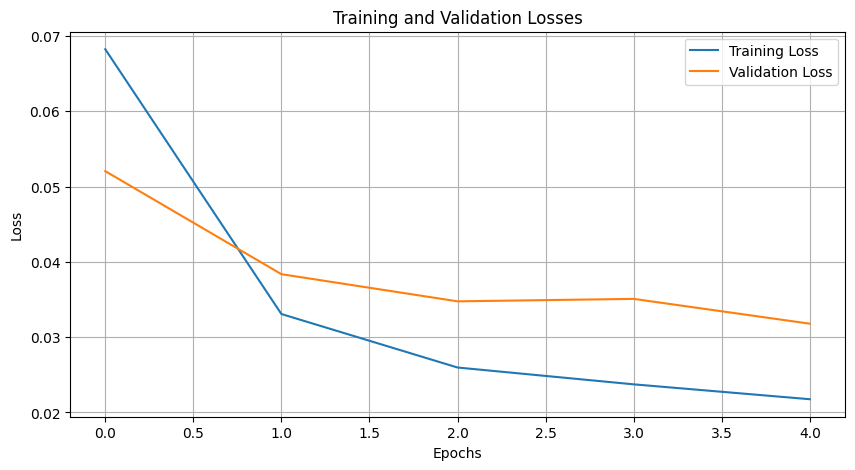

Finished training unet. Model state saved.


In [13]:

# Train each model
for model_info in models:
    # Move model to the appropriate device
    model = model_info['model'].to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = Trainer(model, optimizer, criterion, device, model_name=model_name + "_test")
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs, checkpoint_interval=5)
    
    # Save the trained model state
    torch.save(model.state_dict(), f"{model_name}_state.pth")

    print(f"Finished training {model_name}. Model state saved.")

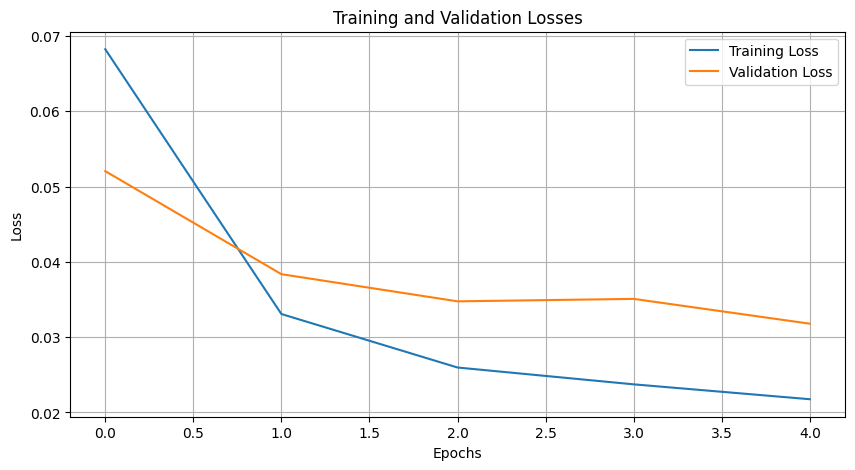

In [14]:
trainer.plot_losses()

In [15]:
trainer.test(test_loader)



Test Loss: 0.0248


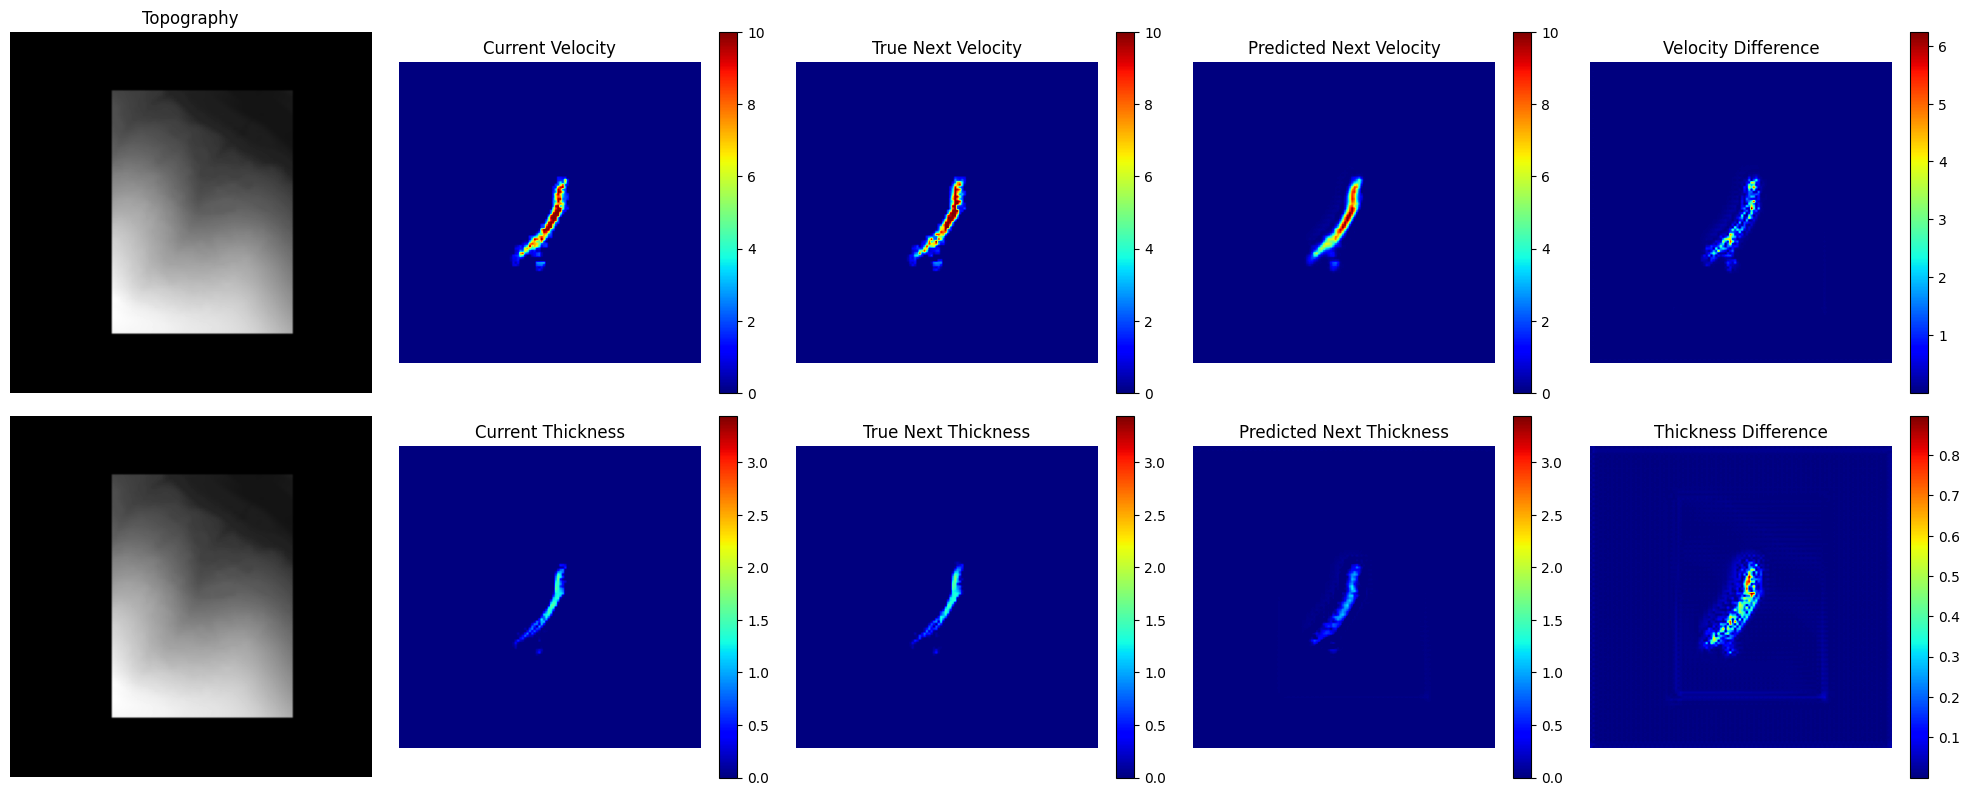

In [16]:
trainer.plot_predictions(test_loader, num_predictions=1)